In [ ]:
df_prueba[]

### Clustering

In [16]:
import pandas as pd
import datetime
from os import listdir
import os, os.path
from os.path import isfile, join
import numpy as np
#from sklearn.metrics import jaccard_similarity_score
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN, MeanShift, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score, silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.util import dataframe_utils

In [3]:
df_prueba=pd.read_csv("./Log of analysis of time aspects.csv",index_col=0)
df_prueba["QY"] = df_prueba["Year"].astype(str) + "-" + df_prueba["Question"]
df_prueba

,case:id,case:concept:name,concept:name,Variant,time:timestamp,Question,Report,Year,Category,Type,Tupla,Organization,QY
0,A2 P4 BPI 2020,A2 P4 BPI 2020,Filter activities,Filter activities by sub-processes,2022-03-11 19:24:15.966942,P4,A2,2020,Student,Manipulation,A22020,"Faculty of Science, Utrecht University",2020-P4
1,A2 P4 BPI 2020,A2 P4 BPI 2020,Group activities,Group activities by sub-processes,2022-03-11 20:24:15.966942,P4,A2,2020,Student,Manipulation,A22020,"Faculty of Science, Utrecht University",2020-P4
2,A2 P4 BPI 2020,A2 P4 BPI 2020,Calculate cycle time,Calculate cycle time for all pairs of events f...,2022-03-11 21:24:15.966942,P4,A2,2020,Student,Analyze Time,A22020,"Faculty of Science, Utrecht University",2020-P4
3,A7 P4 BPI 2020,A7 P4 BPI 2020,Group activities,Group activities by role,2022-03-11 22:24:15.966942,P4,A7,2020,Academic,Manipulation,A72020,German Research Center for Artificial Intellig...,2020-P4
4,A7 P4 BPI 2020,A7 P4 BPI 2020,Calculate throughput,Calculate throughput,2022-03-11 23:24:15.966942,P4,A7,2020,Academic,Analyze Time,A72020,German Research Center for Artificial Intellig...,2020-P4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Group traces,Group traces by activities,2022-04-20 09:24:15.966942,P1-P2,A19,2020,Professional,Manipulation,A192020,Sberbank,2020-P1-P2
951,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Calculate statistics,Calculate Statistics of activities,2022-04-20 10:24:15.966942,P1-P2,A19,2020,Professional,Calculate statistics,A192020,Sberbank,2020-P1-P2
952,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Calculate throughput,Calculate throughput,2022-04-20 11:24:15.966942,P1-P2,A19,2020,Professional,Analyze Time,A192020,Sberbank,2020-P1-P2
953,A19 P1-P2 BPI 2020,A19 P1-P2 BPI 2020,Represent temporal series,Represent temporal series of throughput,2022-04-20 12:24:15.966942,P1-P2,A19,2020,Professional,Representation,A192020,Sberbank,2020-P1-P2


In [96]:
df_prueba[df_prueba["Variant"]== "Represent histograms of cycle time"].groupby("QY")["case:id"].count()/df_prueba.groupby("QY")["case:id"].count()

QY
2015-P5       0.034884
2017-P1       0.033019
2019-P2       0.032432
2020-P1-P2    0.047872
2020-P4       0.021739
2020-P5       0.006623
2020-P6       0.024390
Name: case:id, dtype: float64

In [145]:
def list_agg(vals): 
    return [v for v in vals if v is not None]

def sorensenIndex(list1,list2):
    set1=set(list1)
    set2=set(list2)
    intersection = set1.intersection(set2)
    len1=len(list(set1))
    len2=len(list(set2))
    sorensenIndex=float(2*len(list(intersection)))/(len1+len2)
    return sorensenIndex

df_base = df_prueba.groupby('case:concept:name').agg({'Variant':list_agg, 'Report': 'first','QY': 'first', 'Type':'first', 'Organization':'first','Category':'first'})
df_base = df_base.drop(df_base[df_base['Variant'].apply(lambda x: len(x) == 0)].index).reset_index()
df_pairs = df_base.merge(df_base, how='cross')
df_pairs = df_pairs.drop(df_pairs[df_pairs["case:concept:name_x"] == df_pairs["case:concept:name_y"]].index)
df_pairs['combined'] = df_pairs.apply(lambda row: ''.join(sorted([row['case:concept:name_x'], row['case:concept:name_y']])), axis=1)
df_pairs = df_pairs.drop_duplicates('combined').reset_index(drop=True)
#df_pairs['jaccard'] = df_pairs.apply(lambda row: jaccardIndex(row['opf_x'], row['opf_y']), axis=1)
df_pairs['sorensen'] = df_pairs.apply(lambda row: sorensenIndex(row['Variant_x'], row['Variant_y']), axis=1)


QY
2015-P5        9
2017-P1       21
2019-P2       12
2020-P1-P2    20
2020-P4       17
2020-P5       18
2020-P6       13
Name: case:concept:name, dtype: int64

In [207]:
df_prueba[(df_prueba["concept:name"]=="Find bottlenecks")].groupby("QY")["case:concept:name"].nunique()/df_prueba.groupby("QY")["case:concept:name"].nunique()

QY
2015-P5       0.777778
2017-P1       0.857143
2019-P2       0.250000
2020-P1-P2         NaN
2020-P4       0.117647
2020-P5       0.888889
2020-P6       0.692308
Name: case:concept:name, dtype: float64

In [214]:
(df_prueba.groupby(["QY", "concept:name"])["case:id"].count()/df_prueba.groupby(["QY"])["case:id"].nunique()).unstack(level=0)


QY,2015-P5,2017-P1,2019-P2,2020-P1-P2,2020-P4,2020-P5,2020-P6
concept:name,,,,,,,
Analyze cycle time depending on the events,0.111111,NaN,NaN,NaN,NaN,NaN,NaN
Apply decision trees,0.111111,NaN,NaN,NaN,NaN,NaN,NaN
Apply machine learning techniques,NaN,NaN,0.083333,NaN,NaN,NaN,NaN
Assign resource to each activity,NaN,0.047619,NaN,NaN,NaN,NaN,NaN
Calculate average of activities per trace,NaN,NaN,0.083333,0.05,0.058824,NaN,NaN
Calculate cycle time,1.555556,1.476190,2.583333,1.35,1.000000,1.166667,0.846154
Calculate dates of the development of activities of resources,NaN,NaN,0.166667,NaN,NaN,NaN,NaN
Calculate frequency,0.111111,0.428571,0.083333,0.15,0.117647,0.444444,0.076923
Calculate intervals of time of the traces,NaN,NaN,NaN,NaN,NaN,NaN,0.076923


In [185]:
for i in range (4):
    for j in range (i, 4):
        m = pd.DataFrame(labels[labels==i].reset_index()).merge(pd.DataFrame(labels[labels==j].reset_index()), how='cross')
        m = m.drop(m[m["case:concept:name_x"] == m["case:concept:name_y"]].index)
        m['combined'] = m.apply(lambda row: ''.join(sorted([row['case:concept:name_x'], row['case:concept:name_y']])), axis=1)
        m = m.drop_duplicates('combined').reset_index(drop=True)
        print ( i,j,df_pairs[(df_pairs["combined"].isin(m["combined"]))]["sorensen"].mean())

0 0 0.19586186385272852
0 1 0.14121327901083847
0 2 0.10277553683938298
0 3 0.1021023619796751
1 1 0.19518839830936877
1 2 0.09408361943554533
1 3 0.05838936301531049
2 2 0.14447543784620956
2 3 0.03360310554737889
3 3 0.14806224937527457


0.14121327901083847

In [152]:
[(i,j,df_pairs[(df_pairs["case:concept:name_x"].isin(labels[labels==i].index.values)) & (df_pairs["case:concept:name_y"].isin(labels[labels==j].index.values))]["sorensen"].mean()) for i in range(4) for j in range(4)]

[(0, 0, 0.19586186385272852),
 (0, 1, 0.15564316675433554),
 (0, 2, 0.11632771026724129),
 (0, 3, 0.08510841859560112),
 (1, 0, 0.12796248715299677),
 (1, 1, 0.19518839830936877),
 (1, 2, 0.09761627722488314),
 (1, 3, 0.044952236691806376),
 (2, 0, 0.08840201956741205),
 (2, 1, 0.09029862894696912),
 (2, 2, 0.14447543784620956),
 (2, 3, 0.03476668174720348),
 (3, 0, 0.11826053765633564),
 (3, 1, 0.07250513208242593),
 (3, 2, 0.0324498722471083),
 (3, 3, 0.14806224937527457)]

In [106]:
df_pairs

,Variant_x,Report_x,QY_x,Type_x,Organization_x,Category_x,Variant_y,Report_y,QY_y,Type_y,Organization_y,Category_y,combined,sorensen
0,[Calculate cycle time of the whole process for...,A1,2017-P1,Analyze Time,University of Liechtenstein\nVienna University...,Student,"[Filter traces by activities, Calculate cycle ...",A1,2020-P1-P2,Manipulation,"Technische Universität, Berlin",Academic,2017-P12020-P1-P2,0.000000
1,[Calculate cycle time of the whole process for...,A1,2017-P1,Analyze Time,University of Liechtenstein\nVienna University...,Student,"[Group events by time, Calculate cycle time of...",A1,2019-P2,Manipulation,University of Melbourne,Student,2017-P12019-P2,0.000000
2,[Calculate cycle time of the whole process for...,A1,2017-P1,Analyze Time,University of Liechtenstein\nVienna University...,Student,[Calculate cycle time of the whole process for...,A1,2015-P5,Analyze Time,Meijer & Van der Ham Management Consultants,Professional,2015-P52017-P1,0.095238
3,[Calculate cycle time of the whole process for...,A1,2017-P1,Analyze Time,University of Liechtenstein\nVienna University...,Student,"[Filter traces by activities, Calculate cycle ...",A1,2020-P5,Manipulation,"Technische Universität, Berlin",Academic,2017-P12020-P5,0.000000
4,[Calculate cycle time of the whole process for...,A1,2017-P1,Analyze Time,University of Liechtenstein\nVienna University...,Student,[Filter traces depending on the order of activ...,A1,2020-P6,Manipulation,"Technische Universität, Berlin",Academic,2017-P12020-P6,0.166667
5,[Calculate cycle time of the whole process for...,A1,2017-P1,Analyze Time,University of Liechtenstein\nVienna University...,Student,"[Represent process map with cycle time, Calcul...",A10,2020-P4,Representation,"Internal Audit Department, Rostov-on-Don",Academic,2017-P12020-P4,0.000000
6,"[Filter traces by activities, Calculate cycle ...",A1,2020-P1-P2,Manipulation,"Technische Universität, Berlin",Academic,"[Group events by time, Calculate cycle time of...",A1,2019-P2,Manipulation,University of Melbourne,Student,2019-P22020-P1-P2,0.428571
7,"[Filter traces by activities, Calculate cycle ...",A1,2020-P1-P2,Manipulation,"Technische Universität, Berlin",Academic,[Calculate cycle time of the whole process for...,A1,2015-P5,Analyze Time,Meijer & Van der Ham Management Consultants,Professional,2015-P52020-P1-P2,0.000000
8,"[Filter traces by activities, Calculate cycle ...",A1,2020-P1-P2,Manipulation,"Technische Universität, Berlin",Academic,"[Filter traces by activities, Calculate cycle ...",A1,2020-P5,Manipulation,"Technische Universität, Berlin",Academic,2020-P1-P22020-P5,0.500000
9,"[Filter traces by activities, Calculate cycle ...",A1,2020-P1-P2,Manipulation,"Technische Universität, Berlin",Academic,[Filter traces depending on the order of activ...,A1,2020-P6,Manipulation,"Technische Universität, Berlin",Academic,2020-P1-P22020-P6,0.000000


In [63]:
df_prueba["concept:name"].value_counts()

Calculate cycle time                                                 152
Filter traces                                                         86
Calculate number of elements                                          76
Find bottlenecks                                                      63
Group traces                                                          58
Calculate percentages                                                 55
Represent process map                                                 47
Represent bar charts                                                  36
Calculate statistics                                                  36
Identify attributes                                                   34
Represent histograms                                                  32
Compare cycle time                                                    30
Calculate waiting time                                                27
Represent temporal series                          

In [62]:
df_prueba.loc[df_prueba["concept:name"]=="Calculate cycle time", "Variant"].value_counts()

Calculate cycle time of a fragment of the process for a subset of traces              21
Calculate cycle time for all pairs of events for all traces                           20
Calculate cycle time of the whole process for all traces                              20
Calculate cycle time of the whole process for each subset of traces                   19
Calculate cycle time of the whole process for a subset of traces                      19
Calculate cycle time of only a subset of pairs of events for a subset of traces       10
Calculate cycle time of a fragment of the process for all traces                       9
Calculate cycle time for all pairs of events for each subset of traces                 8
Calculate cycle time for all pairs of events for a subset of traces                    8
Calculate cycle time of only a subset of pairs of events for each subset of traces     7
Calculate cycle time of only a subset of pairs of events for all traces                6
Calculate cycle time 

In [4]:
df_prueba.iloc[:,[1,2]]

,case:concept:name,concept:name
0,A2 P4 BPI 2020,Filter activities
1,A2 P4 BPI 2020,Group activities
2,A2 P4 BPI 2020,Calculate cycle time
3,A7 P4 BPI 2020,Group activities
4,A7 P4 BPI 2020,Calculate throughput
...,...,...
950,A19 P1-P2 BPI 2020,Group traces
951,A19 P1-P2 BPI 2020,Calculate statistics
952,A19 P1-P2 BPI 2020,Calculate throughput
953,A19 P1-P2 BPI 2020,Represent temporal series


In [5]:
df_binaria = df_prueba.iloc[:,[1,2]]
df_binaria.index = df_binaria['case:concept:name']
df_binaria.drop(['case:concept:name'], axis = 'columns', inplace=True)
df_binaria

/Users/resinas/anaconda3/envs/predmon/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,concept:name
case:concept:name,
A2 P4 BPI 2020,Filter activities
A2 P4 BPI 2020,Group activities
A2 P4 BPI 2020,Calculate cycle time
A7 P4 BPI 2020,Group activities
A7 P4 BPI 2020,Calculate throughput
...,...
A19 P1-P2 BPI 2020,Group traces
A19 P1-P2 BPI 2020,Calculate statistics
A19 P1-P2 BPI 2020,Calculate throughput


In [6]:
op_count_matrix = df_prueba.groupby(['case:concept:name', 'concept:name'])['case:id'].count().unstack().fillna(0)
op_count_matrix

concept:name,Analyze cycle time depending on the events,Apply decision trees,Apply machine learning techniques,Assign resource to each activity,Calculate average of activities per trace,Calculate cycle time,Calculate dates of the development of activities of resources,Calculate frequency,Calculate intervals of time of the traces,Calculate number of elements,...,Represent circular charts of attributes of the traces,Represent correlation graph of variables,Represent density diagram of cycle time,Represent heat maps of cycle time and an attribute,Represent histograms,Represent lineal distribution of an attribute by traces,Represent linear tendency of cycle time with respect an attribute,Represent process map,Represent scatterplot of cycle time and an attribute,Represent temporal series
case:concept:name,,,,,,,,,,,,,,,,,,,,,
A1 P1 BPI 2017,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
A1 P1-P2 BPI 2020,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1 P2 BPI 2019,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1 P5 BPI 2015,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
A1 P5 BPI 2020,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A8 P1 BPI 2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A8 P5 BPI 2015,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A9 P1 BPI 2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
op_exists_matrix = op_count_matrix > 0
op_exists_matrix

concept:name,Analyze cycle time depending on the events,Apply decision trees,Apply machine learning techniques,Assign resource to each activity,Calculate average of activities per trace,Calculate cycle time,Calculate dates of the development of activities of resources,Calculate frequency,Calculate intervals of time of the traces,Calculate number of elements,...,Represent circular charts of attributes of the traces,Represent correlation graph of variables,Represent density diagram of cycle time,Represent heat maps of cycle time and an attribute,Represent histograms,Represent lineal distribution of an attribute by traces,Represent linear tendency of cycle time with respect an attribute,Represent process map,Represent scatterplot of cycle time and an attribute,Represent temporal series
case:concept:name,,,,,,,,,,,,,,,,,,,,,
A1 P1 BPI 2017,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
A1 P1-P2 BPI 2020,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A1 P2 BPI 2019,False,False,False,False,False,True,False,True,False,True,...,True,False,False,False,False,False,False,False,False,False
A1 P5 BPI 2015,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
A1 P5 BPI 2020,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A8 P1 BPI 2017,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A8 P5 BPI 2015,True,False,False,False,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
A9 P1 BPI 2017,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [6]:
X_one_hot = pd.get_dummies(df_binaria)
X_one_hot = X_one_hot.groupby(['case:concept:name']).sum()
matriz = X_one_hot.where(X_one_hot<1, 1)
matriz.head()

,concept:name_Analyze cycle time depending on the events,concept:name_Apply decision trees,concept:name_Apply machine learning techniques,concept:name_Assign resource to each activity,concept:name_Calculate average of activities per trace,concept:name_Calculate cycle time,concept:name_Calculate dates of the development of activities of resources,concept:name_Calculate frequency,concept:name_Calculate intervals of time of the traces,concept:name_Calculate number of elements,...,concept:name_Represent circular charts of attributes of the traces,concept:name_Represent correlation graph of variables,concept:name_Represent density diagram of cycle time,concept:name_Represent heat maps of cycle time and an attribute,concept:name_Represent histograms,concept:name_Represent lineal distribution of an attribute by traces,concept:name_Represent linear tendency of cycle time with respect an attribute,concept:name_Represent process map,concept:name_Represent scatterplot of cycle time and an attribute,concept:name_Represent temporal series
case:concept:name,,,,,,,,,,,,,,,,,,,,,
A1 P1 BPI 2017,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
A1 P1-P2 BPI 2020,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1 P2 BPI 2019,0,0,0,0,0,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
A1 P5 BPI 2015,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
A1 P5 BPI 2020,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### K-Means

In [12]:
#matriz = op_count_matrix
matriz = op_exists_matrix

clusters = [KMeans(n_clusters=i, random_state=0).fit(matriz) for i in range(2,10)]
pd.DataFrame([(i, silhouette_score(matriz, c.labels_), calinski_harabasz_score(matriz, c.labels_)) for i,c in enumerate(clusters, 2)], columns=['ID','SILHOUETTE', 'CALINSKI'])


,ID,SILHOUETTE,CALINSKI
0,2,0.151218,14.720339
1,3,0.091314,11.129114
2,4,0.120622,9.384740
3,5,0.073611,8.446427
4,6,0.067507,7.693016
5,7,0.058263,6.899321
6,8,0.070595,6.801810
7,9,0.067865,6.139199


In [ ]:
matriz[clusters[2].labels_ !=3][matriz.index.groupby(clusters[2].labels_)[3].str.contains("P4 BPI 2020")].T.sum(axis=1)

In [253]:
p4 = matriz[clusters[2].labels_ ==3][matriz.index.groupby(clusters[2].labels_)[3].str.contains("P4 BPI 2020")].index

In [266]:
a = matriz[(~matriz.index.isin(p4)) & (matriz.index.str.contains("P4 BPI 2020"))].mean(axis=0)

In [267]:
b = matriz[clusters[2].labels_ ==3][matriz.index.groupby(clusters[2].labels_)[3].str.contains("P4 BPI 2020")].T.mean(axis=1)

In [268]:
pd.concat([a,b], axis=1)

,0,1
concept:name,,
Analyze cycle time depending on the events,0.0,0.000000
Apply decision trees,0.0,0.000000
Apply machine learning techniques,0.0,0.000000
Assign resource to each activity,0.0,0.000000
Calculate average of activities per trace,0.2,0.000000
Calculate cycle time,0.6,0.666667
Calculate dates of the development of activities of resources,0.0,0.000000
Calculate frequency,0.4,0.000000
Calculate intervals of time of the traces,0.0,0.000000


In [236]:
matriz.groupby(clusters[2].labels_).mean()

concept:name,Analyze cycle time depending on the events,Apply decision trees,Apply machine learning techniques,Assign resource to each activity,Calculate average of activities per trace,Calculate cycle time,Calculate dates of the development of activities of resources,Calculate frequency,Calculate intervals of time of the traces,Calculate number of elements,...,Represent circular charts of attributes of the traces,Represent correlation graph of variables,Represent density diagram of cycle time,Represent heat maps of cycle time and an attribute,Represent histograms,Represent lineal distribution of an attribute by traces,Represent linear tendency of cycle time with respect an attribute,Represent process map,Represent scatterplot of cycle time and an attribute,Represent temporal series
0,0.058824,0.000000,0.058824,0.000000,0.058824,0.941176,0.058824,0.529412,0.000000,0.705882,...,0.117647,0.000000,0.000000,0.000000,0.470588,0.058824,0.058824,0.470588,0.058824,0.058824
1,0.000000,0.034483,0.000000,0.000000,0.068966,0.965517,0.000000,0.103448,0.000000,0.448276,...,0.034483,0.034483,0.068966,0.000000,0.275862,0.000000,0.034483,0.137931,0.000000,0.103448
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000,0.125000,0.000000,0.000000,0.625000,...,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.250000,0.625000
3,0.000000,0.000000,0.000000,0.017857,0.000000,0.696429,0.000000,0.089286,0.017857,0.107143,...,0.000000,0.000000,0.000000,0.035714,0.125000,0.000000,0.017857,0.357143,0.017857,0.000000


In [20]:
pd.Series(silhouette_samples(matriz, clusters[2].labels_)).groupby(clusters[2].labels_).mean()


0   -0.033180
1    0.052261
2    0.084863
3    0.207821
dtype: float64

In [13]:
def muestra_agrupacion(puntos, clusters):
    puntos_2D = pd.DataFrame(PCA(n_components=2).fit_transform(puntos), columns=['x', 'y'])
    puntos_2D['grupo'] = clusters
    numero_grupos = len(pd.Series(clusters).unique())
    
    plt.figure(figsize=(5,5))
    paleta = sns.color_palette("bright", numero_grupos)
    sns.scatterplot(x='x', y='y', hue='grupo', data=puntos_2D, palette=paleta)
    plt.xticks([], [])
    plt.xlabel('')
    plt.yticks([], [])
    plt.ylabel('')
    plt.show()

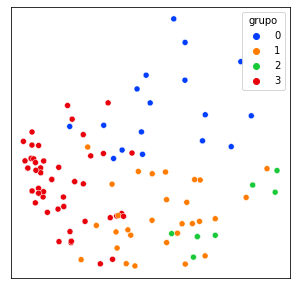

Cluster 1
A1 P1 BPI 2017
A11 P1 BPI 2017
A11 P2 BPI 2019
A11 P5 BPI 2020
A12 P1 BPI 2017
A15 P2 BPI 2019
A16 P5 BPI 2020
A2 P2 BPI 2019
A24 P1-P2 BPI 2020
A3 P1 BPI 2017
A3 P2 BPI 2019
A30 P5 BPI 2020
A37 P5 BPI 2020
A5 P2 BPI 2019
A6 P1 BPI 2017
A7 P1 BPI 2017
A8 P5 BPI 2015

Cluster 2
A1 P1-P2 BPI 2020
A1 P2 BPI 2019
A1 P5 BPI 2015
A1 P6 BPI 2020
A10 P1-P2 BPI 2020
A10 P6 BPI 2020
A11 P1-P2 BPI 2020
A11 P4 BPI 2020
A13 P1-P2 BPI 2020
A13 P2 BPI 2019
A16 P1-P2 BPI 2020
A16 P4 BPI 2020
A18 P1-P2 BPI 2020
A2 P1-P2 BPI 2020
A24 P4 BPI 2020
A25 P1-P2 BPI 2020
A26 P1-P2 BPI 2020
A28 P1-P2 BPI 2020
A31 P1-P2 BPI 2020
A35 P1-P2 BPI 2020
A35 P4 BPI 2020
A37 P1-P2 BPI 2020
A37 P6 BPI 2020
A4 P2 BPI 2019
A5 P5 BPI 2015
A6 P5 BPI 2015
A7 P5 BPI 2015
A9 P2 BPI 2019
A9 P5 BPI 2015

Cluster 3
A12 P2 BPI 2019
A14 P2 BPI 2019
A19 P1-P2 BPI 2020
A19 P4 BPI 2020
A19 P5 BPI 2020
A30 P1-P2 BPI 2020
A34 P1-P2 BPI 2020
A7 P1-P2 BPI 2020

Cluster 4
A1 P5 BPI 2020
A10 P1 BPI 2017
A10 P2 BPI 2019
A10 P4 BPI 2

In [14]:
chosen_kmeans = clusters[2]
muestra_agrupacion(matriz, chosen_kmeans.labels_)

columns=['Cluster','P1-P2 BPI 2020','P4 BPI 2020','P5 BPI 2020','P6 BPI 2020', 'P5 BPI 2015', 'P1 BPI 2017']
#columna es el case_ID
df_clusters= pd.DataFrame(columns=columns)
df_clusters2= pd.DataFrame(columns=columns)
for n in range(chosen_kmeans.n_clusters):
    print('Cluster' ,  n+1) 
    a=0
#     b=0
    c=0
    d=0
    e=0
    f=0
    g=0
    for s in range(len(matriz)):
        if (chosen_kmeans.labels_[s] == n):
            print(matriz.index[s])
            if(matriz.index[s].find("P1-P2 BPI 2020") != -1):
                a = a + 1
#             elif(matriz.index[s].find("P2 BPI 2020") != -1):
#                 b = b + 1
            elif(matriz.index[s].find("P4 BPI 2020") != -1):
                c = c + 1
            elif(matriz.index[s].find("P5 BPI 2020") != -1):
                d = d + 1
            elif(matriz.index[s].find("P6 BPI 2020") != -1):
                e = e + 1
            elif(matriz.index[s].find("P5 BPI 2015") != -1):
                f = f + 1
            elif(matriz.index[s].find("P1 BPI 2017") != -1):
                g = g + 1
    df_clusters.loc[n] = (n+1, a*100/9, c*100/8, d*100/9, e*100/9, f*100/6, g*100/17)
    df_clusters2.loc[n] = (n+1, a, c, d, e, f, g)
    print("")

In [235]:
pd.DataFrame(np.around(clusters[2].cluster_centers_, 2), columns=matriz.columns).T

,0,1,2,3
concept:name,,,,
Analyze cycle time depending on the events,0.06,-0.00,-0.00,-0.00
Apply decision trees,-0.00,0.03,-0.00,-0.00
Apply machine learning techniques,0.06,-0.00,-0.00,-0.00
Assign resource to each activity,-0.00,-0.00,-0.00,0.02
Calculate average of activities per trace,0.06,0.07,-0.00,-0.00
Calculate cycle time,0.94,0.97,0.38,0.70
Calculate dates of the development of activities of resources,0.06,-0.00,0.12,-0.00
Calculate frequency,0.53,0.10,0.00,0.09
Calculate intervals of time of the traces,-0.00,-0.00,-0.00,0.02


In [15]:
# Overview of the sizes depending on the kmeans
[matriz.sum(axis=1).groupby(ck.labels_).describe() for ck in clusters]

[   count      mean       std  min  25%  50%  75%   max
 0   69.0  3.855072  1.849287  1.0  2.0  3.0  5.0   9.0
 1   41.0  7.707317  2.694846  3.0  6.0  8.0  9.0  15.0,
    count      mean       std  min  25%  50%   75%   max
 0   45.0  4.466667  2.190890  1.0  3.0  4.0   6.0   9.0
 1   20.0  9.550000  2.258901  6.0  8.0  9.0  11.0  15.0
 2   45.0  4.222222  1.857282  1.0  3.0  4.0   6.0   9.0,
    count      mean       std  min  25%  50%    75%   max
 0   17.0  9.117647  2.546624  6.0  8.0  9.0  11.00  15.0
 1   29.0  5.724138  2.153014  2.0  4.0  6.0   7.00  10.0
 2    8.0  7.875000  2.642374  3.0  7.0  7.5   9.25  12.0
 3   56.0  3.535714  1.606400  1.0  2.0  3.0   5.00   8.0,
    count      mean       std  min  25%  50%   75%   max
 0   37.0  3.837838  1.740267  1.0  3.0  3.0   5.0   9.0
 1   19.0  3.157895  1.607730  1.0  2.0  3.0   4.5   6.0
 2   18.0  9.222222  2.414553  5.0  8.0  9.0  10.0  15.0
 3   26.0  5.346154  2.018758  2.0  4.0  5.0   7.0   9.0
 4   10.0  7.500000  2.505

In [24]:
# Percentage of QY in the answers of each cluster plus the statistics of their size
qy_of_answer = df_prueba.groupby('case:concept:name').first()["QY"]
a = pd.concat([matriz, qy_of_answer], axis=1).groupby([chosen_kmeans.labels_, "QY"])["QY"].count().unstack().fillna(0)
pd.concat([a/a.sum(), matriz.sum(axis=1).groupby(chosen_kmeans.labels_).describe()], axis=1)

,2015-P5,2017-P1,2019-P2,2020-P1-P2,2020-P4,2020-P5,2020-P6,count,mean,std,min,25%,50%,75%,max
0,0.111111,0.285714,0.416667,0.05,0.000000,0.222222,0.000000,17.0,9.117647,2.546624,6.0,8.0,9.0,11.00,15.0
1,0.555556,0.000000,0.333333,0.65,0.235294,0.000000,0.230769,29.0,5.724138,2.153014,2.0,4.0,6.0,7.00,10.0
2,0.000000,0.000000,0.166667,0.20,0.058824,0.055556,0.000000,8.0,7.875000,2.642374,3.0,7.0,7.5,9.25,12.0
3,0.333333,0.714286,0.083333,0.10,0.705882,0.722222,0.769231,56.0,3.535714,1.606400,1.0,2.0,3.0,5.00,8.0


In [229]:
df_pairs[(df_pairs["sorensen"] > 0.7)]

,case:concept:name_x,Variant_x,Report_x,QY_x,Type_x,Organization_x,Category_x,case:concept:name_y,Variant_y,Report_y,QY_y,Type_y,Organization_y,Category_y,combined,sorensen
962,A10 P4 BPI 2020,"[Represent process map with cycle time, Calcul...",A10,2020-P4,Representation,"Internal Audit Department, Rostov-on-Don",Academic,A13 P5 BPI 2020,"[Represent process map with cycle time, Calcul...",A13,2020-P5,Representation,Sberbank,Professional,A10 P4 BPI 2020A13 P5 BPI 2020,0.8
987,A10 P4 BPI 2020,"[Represent process map with cycle time, Calcul...",A10,2020-P4,Representation,"Internal Audit Department, Rostov-on-Don",Academic,A2 P5 BPI 2020,[Calculate cycle time for all pairs of events ...,A2,2020-P5,Analyze Time,"Faculty of Science, Utrecht University",Student,A10 P4 BPI 2020A2 P5 BPI 2020,0.8
988,A10 P4 BPI 2020,"[Represent process map with cycle time, Calcul...",A10,2020-P4,Representation,"Internal Audit Department, Rostov-on-Don",Academic,A2 P6 BPI 2020,[Calculate cycle time for all pairs of events ...,A2,2020-P6,Analyze Time,"Faculty of Science, Utrecht University",Student,A10 P4 BPI 2020A2 P6 BPI 2020,0.8
1056,A10 P5 BPI 2020,[Calculate cycle time for all pairs of events ...,A10,2020-P5,Analyze Time,"Internal Audit Department, Rostov-on-Don",Academic,A12 P6 BPI 2020,[Calculate cycle time for all pairs of events ...,A12,2020-P6,Analyze Time,Sberbank,Professional,A10 P5 BPI 2020A12 P6 BPI 2020,0.8
2058,A12 P4 BPI 2020,[Calculate cycle time for all pairs of events ...,A12,2020-P4,Analyze Time,Sberbank,Professional,A37 P4 BPI 2020,[Calculate cycle time for all pairs of events ...,A37,2020-P4,Analyze Time,Sberbank,Professional,A12 P4 BPI 2020A37 P4 BPI 2020,1.0
2171,A12 P6 BPI 2020,[Calculate cycle time for all pairs of events ...,A12,2020-P6,Analyze Time,Sberbank,Professional,A13 P5 BPI 2020,"[Represent process map with cycle time, Calcul...",A13,2020-P5,Representation,Sberbank,Professional,A12 P6 BPI 2020A13 P5 BPI 2020,0.8
2196,A12 P6 BPI 2020,[Calculate cycle time for all pairs of events ...,A12,2020-P6,Analyze Time,Sberbank,Professional,A2 P5 BPI 2020,[Calculate cycle time for all pairs of events ...,A2,2020-P5,Analyze Time,"Faculty of Science, Utrecht University",Student,A12 P6 BPI 2020A2 P5 BPI 2020,0.8
2197,A12 P6 BPI 2020,[Calculate cycle time for all pairs of events ...,A12,2020-P6,Analyze Time,Sberbank,Professional,A2 P6 BPI 2020,[Calculate cycle time for all pairs of events ...,A2,2020-P6,Analyze Time,"Faculty of Science, Utrecht University",Student,A12 P6 BPI 2020A2 P6 BPI 2020,0.8
2204,A12 P6 BPI 2020,[Calculate cycle time for all pairs of events ...,A12,2020-P6,Analyze Time,Sberbank,Professional,A25 P4 BPI 2020,[Calculate cycle time for all pairs of events ...,A25,2020-P4,Analyze Time,¿?,Student,A12 P6 BPI 2020A25 P4 BPI 2020,0.8
2205,A12 P6 BPI 2020,[Calculate cycle time for all pairs of events ...,A12,2020-P6,Analyze Time,Sberbank,Professional,A25 P5 BPI 2020,[Calculate cycle time for all pairs of events ...,A25,2020-P5,Analyze Time,¿?,Student,A12 P6 BPI 2020A25 P5 BPI 2020,0.8


In [226]:
df_pairs[((((df_pairs["QY_x"]=="2020-P4") & (df_pairs["QY_y"]=="2020-P5")) | ((df_pairs["QY_y"]=="2020-P4") & (df_pairs["QY_x"]=="2020-P5")))) & (df_pairs["sorensen"] > 0.5)]

,case:concept:name_x,Variant_x,Report_x,QY_x,Type_x,Organization_x,Category_x,case:concept:name_y,Variant_y,Report_y,QY_y,Type_y,Organization_y,Category_y,combined,sorensen
496,A1 P5 BPI 2020,"[Filter traces by activities, Calculate cycle ...",A1,2020-P5,Manipulation,"Technische Universität, Berlin",Academic,A28 P4 BPI 2020,"[Preprocess the traces of the logs, Calculate ...",A28,2020-P4,Manipulation,Sberbank,Professional,A1 P5 BPI 2020A28 P4 BPI 2020,0.571429
962,A10 P4 BPI 2020,"[Represent process map with cycle time, Calcul...",A10,2020-P4,Representation,"Internal Audit Department, Rostov-on-Don",Academic,A13 P5 BPI 2020,"[Represent process map with cycle time, Calcul...",A13,2020-P5,Representation,Sberbank,Professional,A10 P4 BPI 2020A13 P5 BPI 2020,0.800000
987,A10 P4 BPI 2020,"[Represent process map with cycle time, Calcul...",A10,2020-P4,Representation,"Internal Audit Department, Rostov-on-Don",Academic,A2 P5 BPI 2020,[Calculate cycle time for all pairs of events ...,A2,2020-P5,Analyze Time,"Faculty of Science, Utrecht University",Student,A10 P4 BPI 2020A2 P5 BPI 2020,0.800000
1094,A10 P5 BPI 2020,[Calculate cycle time for all pairs of events ...,A10,2020-P5,Analyze Time,"Internal Audit Department, Rostov-on-Don",Academic,A25 P4 BPI 2020,[Calculate cycle time for all pairs of events ...,A25,2020-P4,Analyze Time,¿?,Student,A10 P5 BPI 2020A25 P4 BPI 2020,0.666667
2509,A13 P4 BPI 2020,"[Represent process map with cycle time, Calcul...",A13,2020-P4,Representation,Sberbank,Professional,A13 P5 BPI 2020,"[Represent process map with cycle time, Calcul...",A13,2020-P5,Representation,Sberbank,Professional,A13 P4 BPI 2020A13 P5 BPI 2020,0.571429
2534,A13 P4 BPI 2020,"[Represent process map with cycle time, Calcul...",A13,2020-P4,Representation,Sberbank,Professional,A2 P5 BPI 2020,[Calculate cycle time for all pairs of events ...,A2,2020-P5,Analyze Time,"Faculty of Science, Utrecht University",Student,A13 P4 BPI 2020A2 P5 BPI 2020,0.571429
2624,A13 P5 BPI 2020,"[Represent process map with cycle time, Calcul...",A13,2020-P5,Representation,Sberbank,Professional,A25 P4 BPI 2020,[Calculate cycle time for all pairs of events ...,A25,2020-P4,Analyze Time,¿?,Student,A13 P5 BPI 2020A25 P4 BPI 2020,0.666667
3915,A19 P4 BPI 2020,"[Filter traces by frequency, Group traces by a...",A19,2020-P4,Manipulation,Sberbank,Professional,A19 P5 BPI 2020,"[Filter traces by frequency, Group traces by a...",A19,2020-P5,Manipulation,Sberbank,Professional,A19 P4 BPI 2020A19 P5 BPI 2020,1.000000
4349,A2 P5 BPI 2020,[Calculate cycle time for all pairs of events ...,A2,2020-P5,Analyze Time,"Faculty of Science, Utrecht University",Student,A25 P4 BPI 2020,[Calculate cycle time for all pairs of events ...,A25,2020-P4,Analyze Time,¿?,Student,A2 P5 BPI 2020A25 P4 BPI 2020,0.666667
4770,A25 P4 BPI 2020,[Calculate cycle time for all pairs of events ...,A25,2020-P4,Analyze Time,¿?,Student,A25 P5 BPI 2020,[Calculate cycle time for all pairs of events ...,A25,2020-P5,Analyze Time,¿?,Student,A25 P4 BPI 2020A25 P5 BPI 2020,1.000000


In [46]:
labels = pd.Series(chosen_kmeans.labels_, index=matriz.index)
labels


case:concept:name
A1 P1 BPI 2017       0
A1 P1-P2 BPI 2020    1
A1 P2 BPI 2019       1
A1 P5 BPI 2015       1
A1 P5 BPI 2020       3
                    ..
A8 P1 BPI 2017       3
A8 P5 BPI 2015       0
A9 P1 BPI 2017       3
A9 P2 BPI 2019       1
A9 P5 BPI 2015       1
Length: 110, dtype: int32

In [58]:
pd.concat([labels, df_prueba.groupby('case:concept:name').first()["QY"]], axis=1, keys=["l","c"]).reset_index().groupby(["c", "l"]).count().unstack()

case:concept:name                 
l                          0     1    2     3
c                                            
2015-P5                  1.0   5.0  NaN   3.0
2017-P1                  6.0   NaN  NaN  15.0
2019-P2                  5.0   4.0  2.0   1.0
2020-P1-P2               1.0  13.0  4.0   2.0
2020-P4                  NaN   4.0  1.0  12.0
2020-P5                  4.0   NaN  1.0  13.0
2020-P6                  NaN   3.0  NaN  10.0

In [211]:
# Weight of each QY in each cluster
(a.T/a.sum(axis=1))

,0,1,2,3
QY,,,,
2015-P5,0.058824,0.172414,0.000,0.053571
2017-P1,0.352941,0.000000,0.000,0.267857
2019-P2,0.294118,0.137931,0.250,0.017857
2020-P1-P2,0.058824,0.448276,0.500,0.035714
2020-P4,0.000000,0.137931,0.125,0.214286
2020-P5,0.235294,0.000000,0.125,0.232143
2020-P6,0.000000,0.103448,0.000,0.178571


In [212]:
# Size of the answers of the cluster (considering counts)
op_count_matrix.sum(axis=1).groupby(chosen_kmeans.labels_).describe()

,count,mean,std,min,25%,50%,75%,max
0,17.0,19.117647,12.154641,6.0,11.00,16.0,27.00,56.0
1,29.0,8.724138,4.366239,2.0,6.00,8.0,11.00,20.0
2,8.0,16.250000,7.206148,4.0,11.75,17.5,19.25,27.0
3,56.0,4.410714,2.715456,1.0,2.75,3.0,6.00,13.0


In [272]:
labels

case:concept:name
A1 P1 BPI 2017       0
A1 P1-P2 BPI 2020    1
A1 P2 BPI 2019       1
A1 P5 BPI 2015       1
A1 P5 BPI 2020       3
                    ..
A8 P1 BPI 2017       3
A8 P5 BPI 2015       0
A9 P1 BPI 2017       3
A9 P2 BPI 2019       1
A9 P5 BPI 2015       1
Length: 110, dtype: int32

In [285]:
l = pd.concat([df_prueba.groupby("case:concept:name")["Category"].first(), labels], axis=1).value_counts().sort_index().groupby("Category").sum()

pd.concat([df_prueba.groupby("case:concept:name")["Category"].first(), labels], axis=1).value_counts().sort_index().unstack(level=1).T/ l



Category,Academic,Professional,Student
0,,,
0,0.037037,0.127273,0.321429
1,0.333333,0.272727,0.178571
2,0.148148,0.072727,NaN
3,0.481481,0.527273,0.500000


In [227]:


(matriz.groupby(chosen_kmeans.labels_).sum()/matriz.sum()).T

,0,1,2,3
concept:name,,,,
Analyze cycle time depending on the events,1.000000,0.000000,0.000000,0.000000
Apply decision trees,0.000000,1.000000,0.000000,0.000000
Apply machine learning techniques,1.000000,0.000000,0.000000,0.000000
Assign resource to each activity,0.000000,0.000000,0.000000,1.000000
Calculate average of activities per trace,0.333333,0.666667,0.000000,0.000000
Calculate cycle time,0.186047,0.325581,0.034884,0.453488
Calculate dates of the development of activities of resources,0.500000,0.000000,0.500000,0.000000
Calculate frequency,0.529412,0.176471,0.000000,0.294118
Calculate intervals of time of the traces,0.000000,0.000000,0.000000,1.000000


In [22]:
# Percentage of answers in each cluster in which the operation appears
matriz.groupby(chosen_kmeans.labels_).mean().transpose()

,0,1,2,3
concept:name,,,,
Analyze cycle time depending on the events,0.058824,0.000000,0.000,0.000000
Apply decision trees,0.000000,0.034483,0.000,0.000000
Apply machine learning techniques,0.058824,0.000000,0.000,0.000000
Assign resource to each activity,0.000000,0.000000,0.000,0.017857
Calculate average of activities per trace,0.058824,0.068966,0.000,0.000000
Calculate cycle time,0.941176,0.965517,0.375,0.696429
Calculate dates of the development of activities of resources,0.058824,0.000000,0.125,0.000000
Calculate frequency,0.529412,0.103448,0.000,0.089286
Calculate intervals of time of the traces,0.000000,0.000000,0.000,0.017857


# Conclusions

The conclusion is that this clustering classifies the answers in four broad groups:

Group 0: The exhaustive (17 reports). This group includes the longest reports with an average number of 9 different operations and 19 steps. It is mostly composed of 19, 17 and 20C (i.e. a mix of fragments and finding bottlenecks). In fact, it includes a signifcant part of the reports of 19. Almost all reports use calculate cycle time. It applies several manipulation operations like filter and groupings, it computes statistics, percentages and frequencies, and it also finds bottlenecks, and represents graphical information in a higher proportion than the others.

Group 1: Difference finder (29 reports). This groups includes average sized reports with 5 different operations and 8 steps. It is mostly composed of 20A and in a lower proportion 15, 17, ... In fact, it includes the majority of the reports of 20A and also of 15. Almost all reports use calculate cycle time, and filter traces. However, the main difference with the other groups is the use of compare cycle time. It also has the higher percentage of compute throughput, although it is used only in 20% of the reports. Histograms are also used here, but in a lower proportiona than Group 0.

Group 2: The manipulator (8 reports). This group also includes large reports, closer to those at Group 0, with an average number of 8 different operations and 16 steps. It is mostly composed of 20A and 19 with 20B and 20C in a much lower proportion). It is characterized by the lower use of calculate cycle time. Instead it computes many statistics, and applies manipulation operations like filters and groups. Actually, the use of groups is significantly higher in this than in the others. Also, unlike the other groups, it uses temporal series representation as a key part of the analyses.

Group 3: Bottleneck finder (56 reports). This groups includes the shorter reports with 3.8 different operations and 4.4 steps. It is mostly composed of 17, 20B, 20C and 20D. It also includes a 33% of 15. The use of calculate cycle time is significant, but not as high as in Groups 0 and 1 (69%). It is also characterized by the high use of find bottlenecks (69%), which is higher than in all the other cases, and the low use of manipulation operations. In particular, filters, which is very high in the other cases. As for the representation it uses process maps and histograms like Group 0, but in a much lower proportion.

In [10]:
cluster1 = pd.DataFrame()
cluster2 = pd.DataFrame()
cluster3 = pd.DataFrame()
cluster4 = pd.DataFrame()
cluster5 = pd.DataFrame()
cluster6 = pd.DataFrame()
row=0

for n in range(kmeans6.n_clusters):
    for s in range(len(matriz)):
        if (kmeans6.labels_[s] == n):
            for row in range(len(df_prueba)):
                if (df_prueba['case:concept:name'][row] == matriz.index[s]):
                    new_row=df_prueba.iloc[row]
                    if(n==0):
                        cluster1 = cluster1.append(new_row, ignore_index=True)
                    elif(n==1):
                        cluster2 = cluster2.append(new_row, ignore_index=True)
                    elif(n==2):
                        cluster3 = cluster3.append(new_row, ignore_index=True)
                    elif(n==3):
                        cluster4 = cluster4.append(new_row, ignore_index=True)
                    elif(n==4):
                        cluster5 = cluster5.append(new_row, ignore_index=True)
                    elif(n==5):
                        cluster6 = cluster6.append(new_row, ignore_index=True)

In [11]:
df_clusters.to_csv('info-clusters.csv')
df_clusters2.to_csv('info-clusters2.csv')
cluster1.to_csv('cluster1.csv')
cluster2.to_csv('cluster2.csv')
cluster3.to_csv('cluster3.csv')
cluster4.to_csv('cluster4.csv')
cluster5.to_csv('cluster5.csv')
cluster6.to_csv('cluster6.csv')

In [12]:
log2 = log_converter.apply(cluster2)
xes_exporter.apply(log2, './Cluster 2 kmeans.xes')

log1 = log_converter.apply(cluster1)
xes_exporter.apply(log1, './Cluster 1 kmeans.xes')

log3 = log_converter.apply(cluster3)
xes_exporter.apply(log3, './Cluster 3 kmeans.xes')

log4 = log_converter.apply(cluster4)
xes_exporter.apply(log4, './Cluster 4 kmeans.xes')

log5 = log_converter.apply(cluster5)
xes_exporter.apply(log5, './Cluster 5 kmeans.xes')

log6 = log_converter.apply(cluster6)
xes_exporter.apply(log6, './Cluster 6 kmeans.xes')

exporting log, completed traces :: 100%|██████████| 23/23 [00:00<00:00, 1677.37it/s]


### AgglomerativeClustering

Linkage:
- 'ward' minimiza la variación de los grupos que se fusionan. --> por defecto

- "average" utiliza el promedio de las distancias de cada observación de los dos conjuntos.

- "complete" utiliza las distancias máximas entre todas las observaciones de los dos conjuntos.

In [159]:
METRICAS2 = pd.DataFrame(columns=['SILHOUETTE', 'CALINSKI'])

agc = AgglomerativeClustering(n_clusters=2).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-2'] = (silhouette_score(matriz, agc.labels_), calinski_harabasz_score(matriz, agc.labels_))

agc3 = AgglomerativeClustering(n_clusters=3).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-3'] = (silhouette_score(matriz, agc3.labels_), calinski_harabasz_score(matriz, agc3.labels_))

agc4 = AgglomerativeClustering(n_clusters=4).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-4'] = (silhouette_score(matriz, agc4.labels_), calinski_harabasz_score(matriz, agc4.labels_))

agc5 = AgglomerativeClustering(n_clusters=5).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-5'] = (silhouette_score(matriz, agc5.labels_) , calinski_harabasz_score(matriz, agc5.labels_))

agc6 = AgglomerativeClustering(n_clusters=6).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-6'] = (silhouette_score(matriz, agc6.labels_), calinski_harabasz_score(matriz, agc6.labels_))

agc7 = AgglomerativeClustering(n_clusters=7).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-7'] = (silhouette_score(matriz, agc7.labels_), calinski_harabasz_score(matriz, agc7.labels_))

agc8 = AgglomerativeClustering(n_clusters=8).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-8'] = (silhouette_score(matriz, agc8.labels_) , calinski_harabasz_score(matriz, agc8.labels_))

agc9 = AgglomerativeClustering(n_clusters=9).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-9'] = (silhouette_score(matriz, agc9.labels_) , calinski_harabasz_score(matriz, agc9.labels_))

agc10 = AgglomerativeClustering(n_clusters=10).fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-10'] = (silhouette_score(matriz, agc10.labels_), calinski_harabasz_score(matriz, agc10.labels_))


METRICAS2

,SILHOUETTE,CALINSKI
AGGLOMERATIVE-2,0.087396,12.061502
AGGLOMERATIVE-3,0.083896,9.640603
AGGLOMERATIVE-4,0.087083,8.753997
AGGLOMERATIVE-5,0.097004,8.060383
AGGLOMERATIVE-6,0.089900,7.509383
AGGLOMERATIVE-7,0.100116,7.142561
AGGLOMERATIVE-8,0.107909,6.863979
AGGLOMERATIVE-9,0.113773,6.677171
AGGLOMERATIVE-10,0.120338,6.521793


In [160]:
METRICAS3 = pd.DataFrame(columns=['SILHOUETTE', 'CALINSKI'])
a= AgglomerativeClustering(n_clusters=2, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='ward', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-2-defecto'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=6, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='ward', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-6-defecto'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=2, affinity='manhattan', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='average', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-2-manh-av'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=6, affinity='manhattan', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='average', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-6-manh-av'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=2, affinity='manhattan', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='complete', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-2-manh-comp'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=6, affinity='manhattan', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='complete', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-6-manh-comp'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=2, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='single', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-2-cos-sing'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))
a= AgglomerativeClustering(n_clusters=6, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', 
                           linkage='single', distance_threshold=None).fit(matriz)
METRICAS3.loc['Agglomerative-6-cos-sing'] = (silhouette_score(matriz, a.labels_) , calinski_harabasz_score(matriz, a.labels_))

METRICAS3

,SILHOUETTE,CALINSKI
Agglomerative-2-defecto,0.087396,12.061502
Agglomerative-6-defecto,0.089900,7.509383
Agglomerative-2-manh-av,0.272395,2.657365
Agglomerative-6-manh-av,0.140084,2.526331
Agglomerative-2-manh-comp,0.118736,12.346825
Agglomerative-6-manh-comp,0.060631,6.483740
Agglomerative-2-cos-sing,0.257243,2.475251
Agglomerative-6-cos-sing,0.144453,2.394098


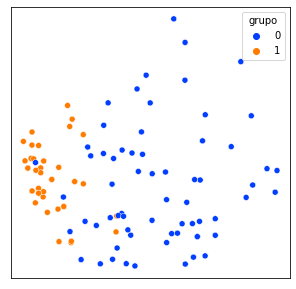

Cluster 1
A1 P1-P2 BPI 2020
A1 P2 BPI 2019
A1 P5 BPI 2015
A10 P1-P2 BPI 2020
A10 P2 BPI 2019
A10 P6 BPI 2020
A11 P1 BPI 2017
A11 P1-P2 BPI 2020
A11 P2 BPI 2019
A11 P4 BPI 2020
A11 P5 BPI 2020
A12 P1 BPI 2017
A12 P2 BPI 2019
A13 P1 BPI 2017
A13 P1-P2 BPI 2020
A13 P2 BPI 2019
A14 P1 BPI 2017
A14 P2 BPI 2019
A15 P2 BPI 2019
A16 P1 BPI 2017
A16 P1-P2 BPI 2020
A16 P4 BPI 2020
A16 P5 BPI 2020
A18 P1-P2 BPI 2020
A19 P1-P2 BPI 2020
A19 P4 BPI 2020
A19 P5 BPI 2020
A2 P1 BPI 2017
A2 P1-P2 BPI 2020
A2 P2 BPI 2019
A22 P1 BPI 2017
A24 P1-P2 BPI 2020
A24 P4 BPI 2020
A25 P1-P2 BPI 2020
A26 P1-P2 BPI 2020
A26 P4 BPI 2020
A27 P1-P2 BPI 2020
A27 P4 BPI 2020
A28 P1-P2 BPI 2020
A3 P1 BPI 2017
A3 P2 BPI 2019
A30 P1-P2 BPI 2020
A30 P5 BPI 2020
A31 P1-P2 BPI 2020
A31 P4 BPI 2020
A34 P1-P2 BPI 2020
A34 P5 BPI 2020
A35 P1-P2 BPI 2020
A35 P4 BPI 2020
A37 P1-P2 BPI 2020
A37 P5 BPI 2020
A37 P6 BPI 2020
A4 P2 BPI 2019
A5 P2 BPI 2019
A5 P5 BPI 2015
A6 P1 BPI 2017
A6 P5 BPI 2015
A7 P1 BPI 2017
A7 P1-P2 BPI 2020
A7 P

In [15]:
muestra_agrupacion(matriz, agc.labels_)

columns=['Cluster','P1-P2 BPI 2020','P4 BPI 2020','P5 BPI 2020','P6 BPI 2020', 'P5 BPI 2015', 'P1 BPI 2017']
#columna es el case_ID
df_clusters3= pd.DataFrame(columns=columns)
for n in range(agc.n_clusters):
    print('Cluster' ,  n+1) 
    a=0
    b=0
    c=0
    d=0
    e=0
    f=0
    g=0
    for s in range(len(matriz)):
        if (agc.labels_[s] == n):
            print(matriz.index[s])
            if(matriz.index[s].find("P1-P2 BPI 2020") != -1):
                a = a + 1
#             elif(matriz.index[s].find("P2 BPI 2020") != -1):
#                 b = b + 1
            elif(matriz.index[s].find("P4 BPI 2020") != -1):
                c = c + 1
            elif(matriz.index[s].find("P5 BPI 2020") != -1):
                d = d + 1
            elif(matriz.index[s].find("P6 BPI 2020") != -1):
                e = e + 1
            elif(matriz.index[s].find("P5 BPI 2015") != -1):
                f = f + 1
            elif(matriz.index[s].find("P1 BPI 2017") != -1):
                g = g + 1
    #df_clusters.loc[n] = (n+1, a*100/9, b*100/9, c*100/8, d*100/9, e*100/9, f*100/6, g*100/17)
    df_clusters3.loc[n] = (n+1, a, c, d, e, f, g)
    print("")

In [16]:
df_clusters3

,Cluster,P1-P2 BPI 2020,P4 BPI 2020,P5 BPI 2020,P6 BPI 2020,P5 BPI 2015,P1 BPI 2017
0,1,19,9,6,2,6,11
1,2,1,8,12,11,3,10


In [17]:
cluster1agc = pd.DataFrame()
cluster2agc = pd.DataFrame()
row=0

for n in range(agc.n_clusters):
    for s in range(len(matriz)):
        if (agc.labels_[s] == n):
            for row in range(len(df_prueba)):
                if (df_prueba['case:concept:name'][row] == matriz.index[s]):
                    new_row=df_prueba.iloc[row]
                    if(n==0):
                        cluster1agc = cluster1agc.append(new_row, ignore_index=True)
                    else:
                        cluster2agc = cluster2agc.append(new_row, ignore_index=True)

In [18]:
#log2agc = log_converter.apply(cluster2agc)
#xes_exporter.apply(log2agc, './Cluster 2 agc.xes')

#log1agc = log_converter.apply(cluster1agc)
#xes_exporter.apply(log1agc, './Cluster 1 agc.xes')

In [168]:
METRICAS2 = pd.DataFrame(columns=['SILHOUETTE', 'CALINSKI'])

agc2AV = AgglomerativeClustering(n_clusters=2, linkage='average').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-2-average'] = (silhouette_score(matriz, agc2AV.labels_), calinski_harabasz_score(matriz, agc2AV.labels_))

agc3AV = AgglomerativeClustering(n_clusters=3, linkage='average').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-3-average'] = (silhouette_score(matriz, agc3AV.labels_), calinski_harabasz_score(matriz, agc3AV.labels_))

agc4AV = AgglomerativeClustering(n_clusters=4, linkage='average').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-4-average'] = (silhouette_score(matriz, agc4AV.labels_), calinski_harabasz_score(matriz, agc4AV.labels_))

agc5AV = AgglomerativeClustering(n_clusters=5, linkage='average').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-5-average'] = (silhouette_score(matriz, agc5AV.labels_) , calinski_harabasz_score(matriz, agc5AV.labels_))

agc6AV = AgglomerativeClustering(n_clusters=6, linkage='average').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-6-average'] = (silhouette_score(matriz, agc6AV.labels_), calinski_harabasz_score(matriz, agc6AV.labels_))

agc2CMP = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-2-complete'] = (silhouette_score(matriz, agc2CMP.labels_), calinski_harabasz_score(matriz, agc2CMP.labels_))

agc3CMP = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-3-complete'] = (silhouette_score(matriz, agc3CMP.labels_), calinski_harabasz_score(matriz, agc3CMP.labels_))

agc4CMP = AgglomerativeClustering(n_clusters=4, linkage='complete').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-4-complete'] = (silhouette_score(matriz, agc4CMP.labels_), calinski_harabasz_score(matriz, agc4CMP.labels_))

agc5CMP = AgglomerativeClustering(n_clusters=5, linkage='complete').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-5-complete'] = (silhouette_score(matriz, agc5CMP.labels_) , calinski_harabasz_score(matriz, agc5CMP.labels_))

agc6CMP = AgglomerativeClustering(n_clusters=6, linkage='complete').fit(matriz)
METRICAS2.loc['AGGLOMERATIVE-6-complete'] = (silhouette_score(matriz, agc6CMP.labels_), calinski_harabasz_score(matriz, agc6CMP.labels_))

METRICAS2

,SILHOUETTE,CALINSKI
AGGLOMERATIVE-2-average,0.272395,2.657365
AGGLOMERATIVE-3-average,0.244565,2.610536
AGGLOMERATIVE-4-average,0.222569,2.593398
AGGLOMERATIVE-5-average,0.189950,2.511985
AGGLOMERATIVE-6-average,0.171274,3.444703
AGGLOMERATIVE-2-complete,0.118736,12.346825
AGGLOMERATIVE-3-complete,0.081797,9.148261
AGGLOMERATIVE-4-complete,0.093714,8.171806
AGGLOMERATIVE-5-complete,0.054089,6.858857
AGGLOMERATIVE-6-complete,0.060631,6.483740


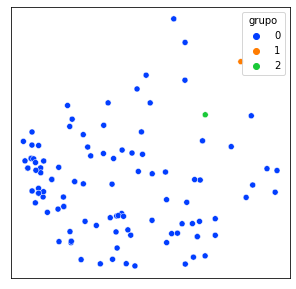

Cluster 0
A1 P1 BPI 2017
A1 P1-P2 BPI 2020
A1 P2 BPI 2019
A1 P5 BPI 2015
A1 P5 BPI 2020
A1 P6 BPI 2020
A10 P1 BPI 2017
A10 P1-P2 BPI 2020
A10 P2 BPI 2019
A10 P4 BPI 2020
A10 P5 BPI 2020
A10 P6 BPI 2020
A11 P1 BPI 2017
A11 P1-P2 BPI 2020
A11 P2 BPI 2019
A11 P4 BPI 2020
A11 P5 BPI 2020
A12 P1-P2 BPI 2020
A12 P2 BPI 2019
A12 P4 BPI 2020
A12 P5 BPI 2020
A12 P6 BPI 2020
A13 P1 BPI 2017
A13 P1-P2 BPI 2020
A13 P2 BPI 2019
A13 P4 BPI 2020
A13 P5 BPI 2020
A13 P6 BPI 2020
A14 P1 BPI 2017
A14 P2 BPI 2019
A15 P1 BPI 2017
A15 P2 BPI 2019
A16 P1 BPI 2017
A16 P1-P2 BPI 2020
A16 P4 BPI 2020
A16 P5 BPI 2020
A16 P6 BPI 2020
A17 P1 BPI 2017
A18 P1 BPI 2017
A18 P1-P2 BPI 2020
A18 P4 BPI 2020
A18 P5 BPI 2020
A19 P1 BPI 2017
A19 P1-P2 BPI 2020
A19 P4 BPI 2020
A19 P5 BPI 2020
A2 P1 BPI 2017
A2 P1-P2 BPI 2020
A2 P2 BPI 2019
A2 P4 BPI 2020
A2 P5 BPI 2015
A2 P5 BPI 2020
A2 P6 BPI 2020
A21 P1 BPI 2017
A22 P1 BPI 2017
A23 P1 BPI 2017
A24 P1-P2 BPI 2020
A24 P4 BPI 2020
A25 P1-P2 BPI 2020
A25 P4 BPI 2020
A25 P5 BPI

In [169]:
muestra_agrupacion(matriz, agc3AV.labels_)


for n in range(agc2AV.n_clusters):
    print('Cluster' ,  n) 
    for s in range(len(matriz)):
        if (agc2AV.labels_[s] == n):
            print(matriz.index[s])
            
                
    print("")

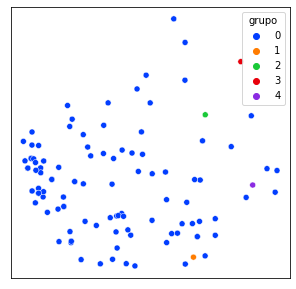

Cluster 0
A1 P1 BPI 2017
A1 P1-P2 BPI 2020
A1 P2 BPI 2019
A1 P5 BPI 2015
A1 P5 BPI 2020
A1 P6 BPI 2020
A10 P1 BPI 2017
A10 P1-P2 BPI 2020
A10 P2 BPI 2019
A10 P4 BPI 2020
A10 P5 BPI 2020
A10 P6 BPI 2020
A11 P1 BPI 2017
A11 P1-P2 BPI 2020
A11 P2 BPI 2019
A11 P4 BPI 2020
A12 P1-P2 BPI 2020
A12 P2 BPI 2019
A12 P4 BPI 2020
A12 P5 BPI 2020
A12 P6 BPI 2020
A13 P1 BPI 2017
A13 P1-P2 BPI 2020
A13 P2 BPI 2019
A13 P4 BPI 2020
A13 P5 BPI 2020
A13 P6 BPI 2020
A14 P1 BPI 2017
A15 P1 BPI 2017
A15 P2 BPI 2019
A16 P1 BPI 2017
A16 P1-P2 BPI 2020
A16 P4 BPI 2020
A16 P5 BPI 2020
A16 P6 BPI 2020
A17 P1 BPI 2017
A18 P1 BPI 2017
A18 P1-P2 BPI 2020
A18 P4 BPI 2020
A18 P5 BPI 2020
A19 P1 BPI 2017
A19 P4 BPI 2020
A19 P5 BPI 2020
A2 P1 BPI 2017
A2 P1-P2 BPI 2020
A2 P2 BPI 2019
A2 P4 BPI 2020
A2 P5 BPI 2015
A2 P5 BPI 2020
A2 P6 BPI 2020
A21 P1 BPI 2017
A22 P1 BPI 2017
A23 P1 BPI 2017
A24 P1-P2 BPI 2020
A24 P4 BPI 2020
A25 P1-P2 BPI 2020
A25 P4 BPI 2020
A25 P5 BPI 2020
A25 P6 BPI 2020
A26 P1-P2 BPI 2020
A26 P4 BPI

In [21]:
muestra_agrupacion(matriz, agc5AV.labels_)


for n in range(agc5AV.n_clusters):
    print('Cluster' ,  n) 
    for s in range(len(matriz)):
        if (agc5AV.labels_[s] == n):
            print(matriz.index[s])
            
    print("")

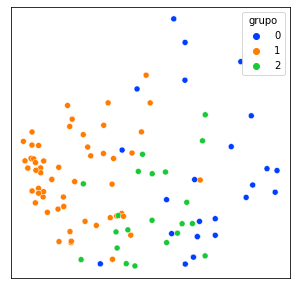

Cluster 1
A11 P2 BPI 2019
A12 P1 BPI 2017
A12 P2 BPI 2019
A13 P1-P2 BPI 2020
A14 P2 BPI 2019
A15 P2 BPI 2019
A16 P1-P2 BPI 2020
A19 P1-P2 BPI 2020
A19 P4 BPI 2020
A19 P5 BPI 2020
A2 P2 BPI 2019
A3 P1 BPI 2017
A30 P1-P2 BPI 2020
A31 P4 BPI 2020
A34 P1-P2 BPI 2020
A35 P1-P2 BPI 2020
A35 P4 BPI 2020
A4 P2 BPI 2019
A5 P5 BPI 2015
A6 P1 BPI 2017
A7 P1 BPI 2017
A7 P1-P2 BPI 2020
A8 P5 BPI 2015
A9 P2 BPI 2019

Cluster 2
A1 P1 BPI 2017
A1 P5 BPI 2015
A10 P1 BPI 2017
A10 P1-P2 BPI 2020
A10 P2 BPI 2019
A10 P4 BPI 2020
A10 P5 BPI 2020
A11 P1 BPI 2017
A12 P1-P2 BPI 2020
A12 P4 BPI 2020
A12 P5 BPI 2020
A12 P6 BPI 2020
A13 P1 BPI 2017
A13 P4 BPI 2020
A13 P5 BPI 2020
A13 P6 BPI 2020
A14 P1 BPI 2017
A15 P1 BPI 2017
A16 P1 BPI 2017
A16 P6 BPI 2020
A17 P1 BPI 2017
A18 P1 BPI 2017
A18 P4 BPI 2020
A18 P5 BPI 2020
A19 P1 BPI 2017
A2 P1 BPI 2017
A2 P4 BPI 2020
A2 P5 BPI 2015
A2 P5 BPI 2020
A2 P6 BPI 2020
A21 P1 BPI 2017
A22 P1 BPI 2017
A23 P1 BPI 2017
A25 P4 BPI 2020
A25 P5 BPI 2020
A25 P6 BPI 2020
A26 P4 B

In [22]:
muestra_agrupacion(matriz, agc3CMP.labels_)
columns=['Cluster','P1 BPI 2020','P2 BPI 2020','P4 BPI 2020','P5 BPI 2020','P6 BPI 2020', 'P5 BPI 2015', 'P1 BPI 2017']
#columna es el case_ID
df_clusters_agg= pd.DataFrame(columns=columns)
for n in range(agc3CMP.n_clusters):
    print('Cluster' ,  n+1) 
    a=0
    b=0
    c=0
    d=0
    e=0
    f=0
    g=0
    for s in range(len(matriz)):
        if (agc3CMP.labels_[s] == n):
            print(matriz.index[s])
            if(matriz.index[s].find("P1 BPI 2020") != -1):
                a = a + 1
            elif(matriz.index[s].find("P2 BPI 2020") != -1):
                b = b + 1
            elif(matriz.index[s].find("P4 BPI 2020") != -1):
                c = c + 1
            elif(matriz.index[s].find("P5 BPI 2020") != -1):
                d = d + 1
            elif(matriz.index[s].find("P6 BPI 2020") != -1):
                e = e + 1
            elif(matriz.index[s].find("P5 BPI 2015") != -1):
                f = f + 1
            elif(matriz.index[s].find("P1 BPI 2017") != -1):
                g = g + 1
    df_clusters_agg.loc[n] = (n+1, a*100/9, b*100/9, c*100/8, d*100/9, e*100/9, f*100/6, g*100/17)
    print("")

In [23]:
df_clusters_agg

,Cluster,P1 BPI 2020,P2 BPI 2020,P4 BPI 2020,P5 BPI 2020,P6 BPI 2020,P5 BPI 2015,P1 BPI 2017
0,1.0,0.0,77.777778,37.5,11.111111,0.000000,33.333333,23.529412
1,2.0,0.0,44.444444,137.5,155.555556,111.111111,100.000000,100.000000
2,3.0,0.0,100.000000,37.5,33.333333,33.333333,16.666667,0.000000
